In [193]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
from model import loss
from model import reverse_se3_diffusion
from scripts import run_inference

import tree
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation

from omegaconf import OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [194]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(reverse_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [195]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False
exp_conf.normalize_pred_score = True

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0
data_conf.digs.crop_len = None
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0
data_conf.digs.crop_len = None

data_conf.rosetta.filtering.max_examples = 1
data_conf.rosetta.filtering.max_len = 150

diff_conf = conf.diffuser
diff_conf.diffuse_trans = True
diff_conf.diffuse_rot = True

diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'exponential'

# print(OmegaConf.to_yaml(conf))

In [196]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Training: 1 examples
INFO: Validation: 1 examples


## Training

In [197]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Training: 1 examples
INFO: Validation: 1 examples


In [198]:
step = 0
epoch = 0
train_losses = defaultdict(list)
log_losses = defaultdict(list)
latest_aux_data = []
sampled_ts = []

In [ ]:
num_epochs = 100000
def update_logs(x,y):
    for k in y:
        if 'loss' in k:
            x[k].append(y[k])
log_freq = 100

exp._model = exp._model.to(device)
exp._model.train()
while epoch < num_epochs:
    epoch += 1
    for train_features in train_loader:
        step += 1
        exp.step = step
        exp.num_epochs = epoch
        sampled_ts.append(train_features['t'])
        train_features = tree.map_structure(
            lambda x: x.to(device), train_features)
        _, aux_data = exp.update_fn(train_features)
        aux_data = tree.map_structure(du.move_to_np, aux_data)
        latest_aux_data.append(aux_data)
        update_logs(train_losses, aux_data)
        update_logs(log_losses, aux_data)
        if step == 1 or step % log_freq == 0:
            print_log = f'Step {step}: '
            for k,v in log_losses.items():
                print_log += f'{k}={np.mean(v):.4f} '
            print(print_log)
            log_losses = defaultdict(list)
            latest_aux_data = []

Step 1: total_loss=2.3047 rot_loss=1.1500 trans_loss=1.1547 
Step 100: total_loss=1.9322 rot_loss=1.1435 trans_loss=0.7887 
Step 200: total_loss=1.4349 rot_loss=1.1217 trans_loss=0.3132 
Step 300: total_loss=1.1706 rot_loss=0.9212 trans_loss=0.2493 
Step 400: total_loss=0.9390 rot_loss=0.7137 trans_loss=0.2253 
Step 500: total_loss=0.8416 rot_loss=0.6321 trans_loss=0.2095 
Step 600: total_loss=0.7776 rot_loss=0.5792 trans_loss=0.1984 
Step 700: total_loss=0.7261 rot_loss=0.5454 trans_loss=0.1807 
Step 800: total_loss=0.6625 rot_loss=0.4937 trans_loss=0.1688 
Step 900: total_loss=0.6282 rot_loss=0.4577 trans_loss=0.1705 
Step 1000: total_loss=0.5801 rot_loss=0.4109 trans_loss=0.1692 
Step 1100: total_loss=0.5358 rot_loss=0.3886 trans_loss=0.1472 
Step 1200: total_loss=0.5125 rot_loss=0.3688 trans_loss=0.1437 
Step 1300: total_loss=0.4891 rot_loss=0.3555 trans_loss=0.1335 
Step 1400: total_loss=0.4576 rot_loss=0.3119 trans_loss=0.1456 
Step 1500: total_loss=0.4261 rot_loss=0.2983 trans_l

In [ ]:
f, axes = plt.subplots(1, 3, figsize=[24, 5])

axes[0].plot(train_losses['rot_loss'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('Rotation loss')

axes[1].plot(train_losses['trans_loss'])
axes[1].set_xlabel('steps')
axes[1].set_ylabel('Translation loss')

axes[2].plot(train_losses['total_loss'])
axes[2].set_xlabel('steps')
axes[2].set_ylabel('Total loss')

In [160]:
ckpt_path = './dev_models/test.pkl'
du.write_checkpoint(
    ckpt_path, exp.model.state_dict(), exp._conf)

Serializing experiment state to ./dev_models/test.pkl


## Data visualization

In [48]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Training: 1 examples
INFO: Validation: 1 examples


In [49]:
train_iter = iter(train_loader)
next_item = next(train_iter)
print(next_item['t'])

tensor([0.0210, 0.9960, 0.8298, 0.6016, 0.6597, 0.5636, 0.1892, 0.3914, 0.3193,
        0.1832, 0.1091, 0.6316, 0.7457, 0.4194, 0.2573, 0.7477],
       dtype=torch.float64)


In [57]:
next_item.keys()

dict_keys(['res_mask', 'res_idx', 'atom_positions', 'rigids_0', 'rigids_t', 'trans_score', 'rot_score', 't', 'rot_score_norm', 'trans_score_norm'])

In [58]:
torch.sum(bb_mask[0])

tensor(125)

In [50]:
# Rigid process function
scale_factor = conf.data.rosetta.scale_factor
bb_mask = next_item['res_mask'].bool()
def process_rigids(rigids, b_idx):
    np_rigids = du.move_to_np(rigids[b_idx][bb_mask[b_idx]])
    se3_vec = au.rigids_to_se3_vec(np_rigids, scale_factor=scale_factor)
    return np_rigids, se3_vec

In [55]:
# Visualize example
b_idx = 2
rigids_t, noisy_se3_vec = process_rigids(next_item['rigids_t'], b_idx)
rigids_0, gt_se3_vec = process_rigids(next_item['rigids_0'], b_idx)


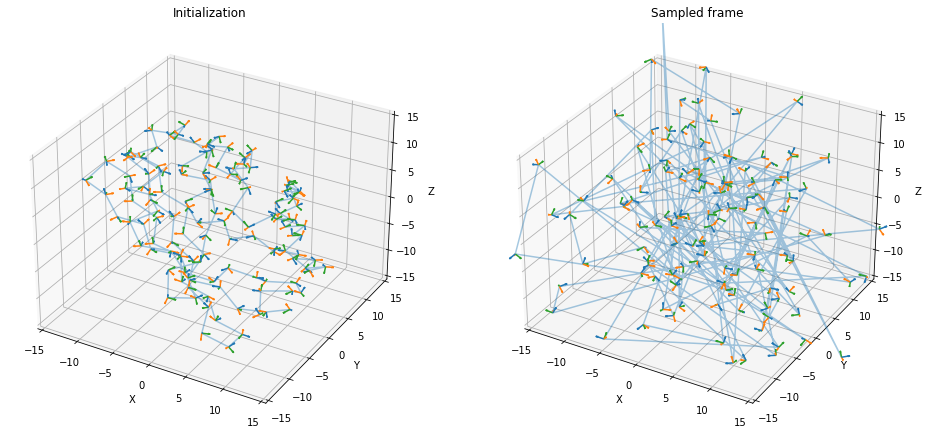

In [56]:
ax_lim = 15
f, axes = plt.subplots(1, 2, figsize=[16, 8], subplot_kw=dict(projection="3d"))
plotting.plot_se3(gt_se3_vec, ax=axes[0], title='Initialization', ax_lim=ax_lim)
plotting.plot_se3(noisy_se3_vec, ax=axes[1], title='Sampled frame', ax_lim=ax_lim)

## Sampling

In [184]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [185]:
# Preprocess init data
exp_diffuser = exp.diffuser
batch_idx = 2
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

rigids_0 = rigids_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]


In [186]:

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.sample_ref(
    num_res,
#     impute=ru.Rigid.from_tensor_7(rigids_0)
).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
#     'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(1.0),
    'rot_score_norm': data_feats['rot_score_norm'],
    'trans_score_norm': data_feats['trans_score_norm'],
}

num_res = res_mask.shape[0]
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
print(f'Sample length {torch.sum(res_mask)}')

Sample length 125.0


In [188]:
# Run inference
infer_out = exp.inference_fn(init_feats, add_noise=True)
sample_rigids = infer_out[0]

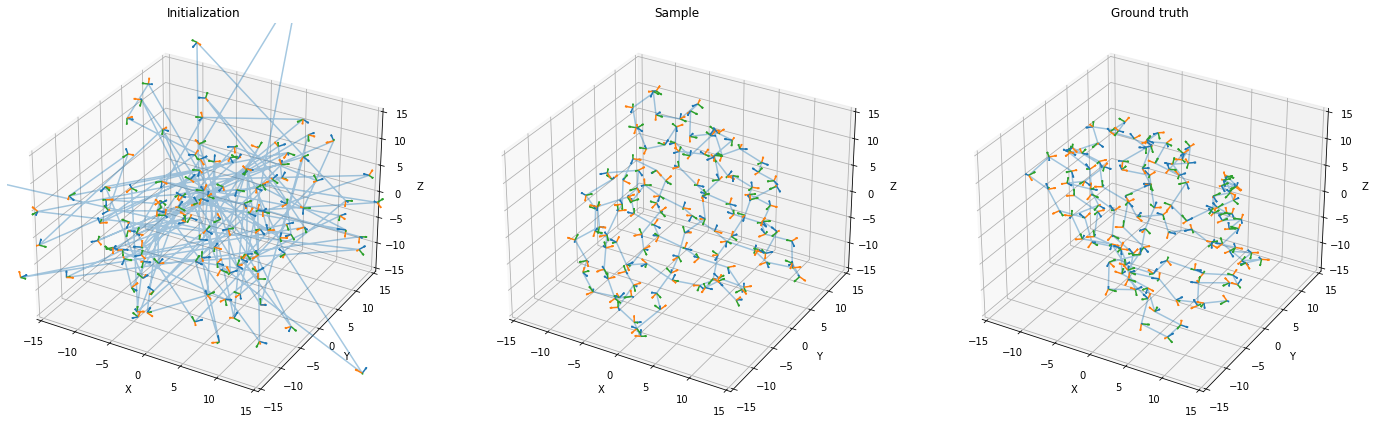

In [189]:
# Plot out SE(3)
final_rigid = sample_rigids[-1][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

In [190]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor,
    return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


FAPE: 0.0319
Ca-RMSD: 1.4931
Alignment rotation: [-158.46177987   66.47578861  -47.74467577]
Alignment translation: [ 6.641922e-08 -5.957877e-08  3.364813e-08]
Alignment reflection: False


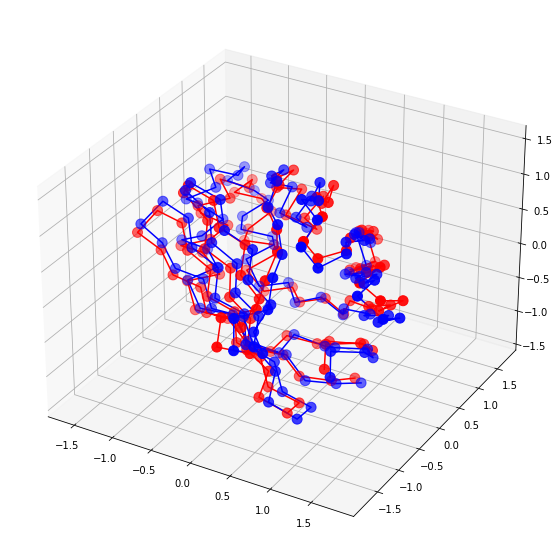

In [191]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')